# Problem Understanding

In this exercise, we will be designing a Long-Short Term Memory (LSTM) model to predict and forecast blood glucose in diabetic patients. Traditional blood glucose monitoring for diabetics has always been tedious and cumbersome, as patients are often required to visit their doctors regularly for blood test, and the blood glucose monitoring device provides glucose reading for that particular time instance. 

Continuous glucose monitoring (CGM) devices that can be attached onto the patient’s arm to actively monitor their blood glucose level are more useful and becoming more common. Here, we use Recurrent Neural Network (RNN) / Long-Short Term Memory (LSTM) models to predict future blood glucose levels, thereby facilitating any adjustment in the amount of insulin to be administered, or earlier detection of any potential disease complication. 

The control of blood glucose level is important for diabetics. According to https://www.medicinenet.com/diabetes_mellitus/article.htm, the blood glucose level of diabetics in milligrams per decilitre (mg/dL) should be maintained between 70 to 120 mg/dL before meals, and under 140mg/dL two hours after eating.  

| Blood glucose level	| Outcome |
|---|---|
| Below 70 mg/dL	| Symptoms of low blood sugar |
| Above 180 mg/dL	| High blood sugar |



## Dataset Description
The table below shows the metadata. Some data may be more important and useful for our model’s prediction.

| Column	| Description |
|---|---|
|RecordID	      |Unique record ID (Entry of record) |
|PatientID	        |Patient ID |
|RecordType	  |Type of record (CGM or Calibration) |
|DeviceDaysFromEnrolment	|Days elapsed from enrolment |
|DeviceDayTimeFromEnrolment	    |Time on the date elapsed from enrolment |
|GlucoseValue	|Ground truth glucose value in mg/dL |


## Data Understanding

In [2]:
!pip3 install gdown
!pip3 install tensorflow
!pip3 install keras

In [3]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/MyDrive/')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
## Change working directory
import os
pset_num = 2
"""
if os.path.exists(f'/content/drive/MyDrive/AIHC/PS{pset_num}') == False:
  os.mkdir('/content/drive/MyDrive/AIHC')
  os.mkdir(f'/content/drive/MyDrive/AIHC/PS{pset_num}')
os.chdir('/content/drive/MyDrive/AIHC/PS2')
print(os.getcwd())
"""

"\nif os.path.exists(f'/content/drive/MyDrive/AIHC/PS{pset_num}') == False:\n  os.mkdir('/content/drive/MyDrive/AIHC')\n  os.mkdir(f'/content/drive/MyDrive/AIHC/PS{pset_num}')\nos.chdir('/content/drive/MyDrive/AIHC/PS2')\nprint(os.getcwd())\n"

In [43]:
## Download data 
dir_data = 'Data.csv'

if os.path.exists(dir_data)==True:
  print("File is found")
else:
  print("File not found")
  !gdown --id 1lxEX9CvKT4KZsASRhDwv5CBjqikwR8ct 
  ## If this method does not work, download from the url below and upload to "/content/drive/MyDrive/AIHC/PS2/Data.csv"
  # url = "https://drive.google.com/file/d/1lxEX9CvKT4KZsASRhDwv5CBjqikwR8ct/view?usp=sharing"

File is found


In [42]:
## Import libraries
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

>❗❗❗ Submit answers to Checkpoints 1, 2 and 3, within ⏰**1 week after the release of the Problem Set**

>💡You may wish to define wrapper functions for train-test-split, training and validation. This will help you tremendously in implementing the for-loop for Checkpoints 8 and 9 while you search for the best window size and changing hyperparameters.

>❓Checkpoint 1: Outline the steps to take to prepare your dataset (e.g. selecting the relevant columns) for time series analysis. 

>🖊 Answer: 

First, I select the columns that are relevant. In this case, we found that there is only one patient and that each records of that particular patient is unique so that is one reason for dropping those two columns. 

Second, using the meaning of calibration, the values are that it's more for calibrating and it's not for measurement on the monitor. Hence, we can drop the rows that has their column of RecordType carrying the value of 'Calibration'.

To get to the steps above, I printed and noticed the data.

Third, I sorted the data according to the DeviceDayFromEnrolment first in order to know when it was last administed to split the graphs into their respective days.

We also sort the timings to plot the sliding windows accordingly.

The code blocks below show how we come to the above steps to be done.

In [44]:
## Load data
data = pd.read_csv(dir_data)
print(data)

## Understand the data
pd.DataFrame.describe(data)


        RecID  PtID  DeviceDaysFromEnrolment DeviceDayTimeFromEnrolment  \
0     9688727   116                        5                   10:47:16   
1     9688728   116                        5                   10:42:16   
2     9688729   116                        5                   10:37:16   
3     9688730   116                        5                   10:32:16   
4     9688731   116                        5                   10:27:16   
...       ...   ...                      ...                        ...   
1803  9715516   116                        4                   19:07:18   
1804  9715517   116                        4                   19:02:20   
1805  9715518   116                        4                   18:57:18   
1806  9715519   116                        4                   18:52:18   
1807  9715520   116                        4                   18:47:18   

     RecordType  GlucoseValue  
0           CGM           233  
1           CGM           240  
2  

,RecID,PtID,DeviceDaysFromEnrolment,GlucoseValue
count,1.808000e+03,1808.0,1808.000000,1808.000000
mean,9.700537e+06,116.0,3.309735,187.674226
std,1.038617e+04,0.0,1.823500,64.569594
min,9.688727e+06,116.0,0.000000,44.000000
25%,9.691634e+06,116.0,2.000000,140.000000
50%,9.695690e+06,116.0,3.000000,184.500000
75%,9.713354e+06,116.0,5.000000,234.250000
max,9.715520e+06,116.0,6.000000,380.000000


In [45]:
pd.DataFrame.head(data)


,RecID,PtID,DeviceDaysFromEnrolment,DeviceDayTimeFromEnrolment,RecordType,GlucoseValue
0,9688727,116,5,10:47:16,CGM,233
1,9688728,116,5,10:42:16,CGM,240
2,9688729,116,5,10:37:16,CGM,248
3,9688730,116,5,10:32:16,CGM,252
4,9688731,116,5,10:27:16,CGM,248


In [46]:
## Pre-process data

### Check for any null values out
data.isnull().values.any() #False

print(data['RecID'])


0       9688727
1       9688728
2       9688729
3       9688730
4       9688731
         ...   
1803    9715516
1804    9715517
1805    9715518
1806    9715519
1807    9715520
Name: RecID, Length: 1808, dtype: int64


In [47]:
## CGM or not?
## Know the number of entries entries that we are supposed to obtain as the resulting data frame
data_cgm = data['RecordType'] == 'CGM'
data[data_cgm].shape #1766 entries that carry CGM
data_calibration = data['RecordType'] == 'Calibration'
data[data_calibration].shape #42 entries that carry calibration

## Data preparation

### Step 1 (Answer in checkpoint 1)
drop_labels =['RecID', 'PtID']
data = data.drop(columns=drop_labels)
print(data)

      DeviceDaysFromEnrolment DeviceDayTimeFromEnrolment RecordType  \
0                           5                   10:47:16        CGM   
1                           5                   10:42:16        CGM   
2                           5                   10:37:16        CGM   
3                           5                   10:32:16        CGM   
4                           5                   10:27:16        CGM   
...                       ...                        ...        ...   
1803                        4                   19:07:18        CGM   
1804                        4                   19:02:20        CGM   
1805                        4                   18:57:18        CGM   
1806                        4                   18:52:18        CGM   
1807                        4                   18:47:18        CGM   

      GlucoseValue  
0              233  
1              240  
2              248  
3              252  
4              248  
...            ...  


In [48]:
### Step 2
data = data[data.RecordType != 'Calibration']


### Step 3 and 4
data = data.sort_values(by=['DeviceDaysFromEnrolment', 'DeviceDayTimeFromEnrolment'],ascending=True)
print('The resulting dataframe is below')
data.to_csv(index=True, path_or_buf='Help.csv')

# train test and split is below

The resulting dataframe is below


>❓Checkpoint 2: Plot the entire time series of the blood glucose levels  (i.e. ground-truth). You may want to use plotting libraries such as matplotlib or seaborn. On the graph that you plotted, show how you split the datapoints into train and test sets. You may want to download the graph, edit it in Paint or Powerpoint, and upload the new graph with annotations using the + Text cell > Insert image command.

>🖊 Answer: From the graph obtained below, We Noticed that the device is plotted into days from when the device is first administered to the patient. Hence, the training set is split into the following intervals for each day. We refer to what we obtain from the second cell to be clearer of the datapoints that we need. To perform the training and testing split we refer to the `generate_train_test` function to determine the training and testing data needed.

The annotations below highlighted in blue refer to the training and that the red refers to the testing dataset.

<img src="help.jpg"></img>

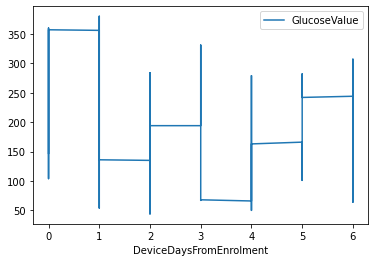

In [49]:
## Plot entire time series
import matplotlib.pyplot as plt
import seaborn as sns

#plot the whole dataset
data.plot(x="DeviceDaysFromEnrolment",y="GlucoseValue")
plt.savefig('device_days.jpeg')


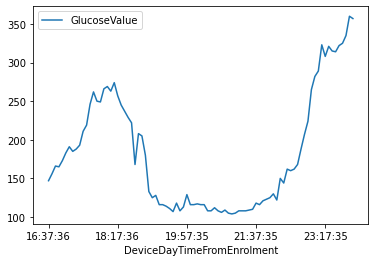

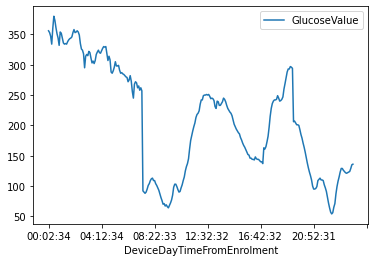

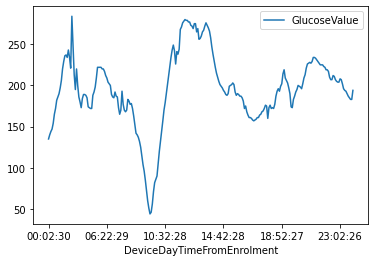

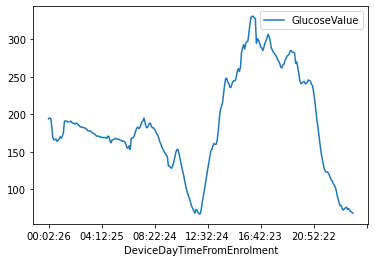

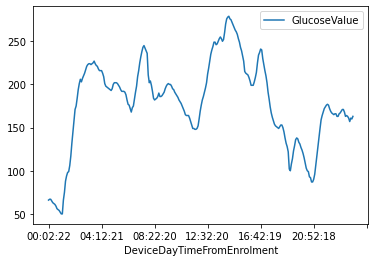

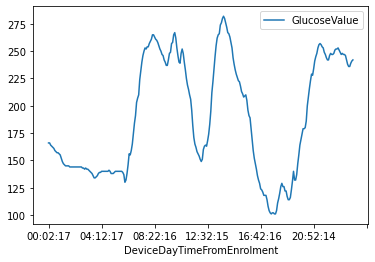

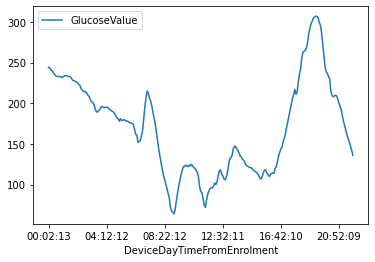

In [50]:
# plot for each day
# my sanity check
num_unique = data['DeviceDaysFromEnrolment'].nunique()
for i in range(num_unique):
    df_plot_days = data[data.DeviceDaysFromEnrolment == i]
    df_plot_days.plot(x='DeviceDayTimeFromEnrolment',y='GlucoseValue')
    plt.savefig(f'Device_Day_{i}.jpeg')

In [55]:
# train-test split
# first step is to set first n training and the next m for test
# by defining the number of sliding windows, we create several windows for testing and training
sliding_window_size = 14


def generate_train_test(window_size, num_days, train_percentage = 0.9):
    print("Our window size is ", sliding_window_size)

    # INITIALISATION
    train_arr = []
    test_arr = []

    for i in range(num_days):
        daily_instance_count = data[data['DeviceDaysFromEnrolment'] == i].count()['DeviceDaysFromEnrolment']
        train_arr.append((data[data["DeviceDaysFromEnrolment"]==i]["GlucoseValue"]).values[0:int(daily_instance_count*train_percentage)])
        
        test_arr.append((data[data["DeviceDaysFromEnrolment"]==i]["GlucoseValue"]).values[int(daily_instance_count*train_percentage):])
    
    X_train=[]
    Y_train=[]
    X_test=[]
    Y_test=[]
    for i in range(0, len(train_arr)): #Creating train and test splits using windows
        for j in range(0, len(train_arr[i])-window_size):
            X_train.append(train_arr[i][j:j+window_size])
            Y_train.append(train_arr[i][j+window_size])
    for i in range(0, len(test_arr)):
        for j in range(0, len(test_arr[i])-window_size):
            X_test.append(test_arr[i][j:j+window_size])
            Y_test.append(test_arr[i][j+window_size])
    X_train = np.array(X_train) #reshaping with third dimension =1 to ensure compatibility with lstm
    X_train=X_train.reshape((X_train.shape[0] ,X_train.shape[1] , 1))
    X_test = np.array(X_test)
    X_test=X_test.reshape((X_test.shape[0] ,X_test.shape[1] , 1))
    Y_train = np.array(Y_train)
    Y_train=Y_train.reshape((Y_train.shape[0]  , 1))
    Y_test = np.array(Y_test)
    Y_test=Y_test.reshape((Y_test.shape[0] , 1))
    
    return X_train, Y_train, X_test, Y_test

In [60]:
X_train, Y_train, X_test, Y_test = generate_train_test(14, num_unique)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

Our window size is  14
(1489, 14, 1)
(86, 14, 1)
(1489, 1)
(86, 1)


>❓Checkpoint 3: Determine the dimensions of your pre-processed data that will be loaded into the model. Show an example printout of your input and output data.

>🖊 Answer: The example printout is above. Window size is 14. Training data loaded is (1489, 1)
Output is dimension of (1,1) 



---



> The rest of the Problem Set to be submitted by the next stipulated deadline.

>❓Checkpoint 4: Construct your LSTM model and show your model architecture. 

> 💡You may want to refer to [this tutorial](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) (Note: There are some minor errors in the pre-processing step, but still good information and usable) or [Keras LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) for more information.

> 💡The following code snippet will be useful in designing a LSTM model:

> ```
import tensorflow as tf
from tensorflow.keras.layers import LSTM
tf.keras.layer.LSTM(·) 
```

> 💡The following code snippet will be useful in producing a graphical output of your model architecture:

> ```
tf.keras.utils.plot_model(·)
```


>🖊 Answer:

>❓Checkpoint 5: Determine the loss function and optimizer, and justify your choice.

> 💡The following code snippet will be useful for defining your loss function and optimizer:
> ``` 
tf.keras.losses.XX
tf.keras.optimizers.XX
```

>🖊 Answer:

In [ ]:
## Create model


In [ ]:
## Plot and print model summary


# Visualizing training

>❓Checkpoint 6: Show the printout and graph of training loss for each epoch.

>🖊 Answer:

>❓Checkpoint 7: Show the graph of the prediction and ground truth across the entire timescale for both the train and test sets. Discuss your findings and suggest how modifications / improvements can be made.

>🖊 Answer:

In [ ]:
## Fit model


In [ ]:
## Plot graph of the prediction and ground truth across the entire timescale for both the train and test sets


## Hyperparameter Optimization
We can try to improve the prediction accuracy of this LSTM model by optimizing some hyperparameters.

>❓Checkpoint 8: Vary the window size (timesteps) and repeat the experiment to find the optimal window size that provides the lowest loss. Show the graph of the losses of your two models (first window size and optimal window size).

>💡You may wish to construct a for-loop that combines train-test-split, training and validation while you search for the best window size.

>🖊 Answer:

In [ ]:
## Redefine window size

## Fit model


>❓Checkpoint 9: Perform a hyperparameter of your choice. Discuss your observation. You may include graphs or printouts to aid in your discussion.

>🖊 Answer:

In [ ]:
## Change hyperparameters

## Fit model


> 💻 End of Problem Set 2 😃



